# use all data of a sin wave to train AAE

1/1 [==============================] - 0s 18ms/step
Epoch 0, Autoencoder Loss: 0.5254, Discriminator Loss: 0.7003
1/1 [==============================] - 0s 9ms/step
Epoch 1, Autoencoder Loss: 0.5020, Discriminator Loss: 0.7377
1/1 [==============================] - 0s 8ms/step
Epoch 2, Autoencoder Loss: 0.4643, Discriminator Loss: 0.6854
1/1 [==============================] - 0s 8ms/step
Epoch 3, Autoencoder Loss: 0.4445, Discriminator Loss: 0.6237
1/1 [==============================] - 0s 9ms/step
Epoch 4, Autoencoder Loss: 0.4299, Discriminator Loss: 0.6429
1/1 [==============================] - 0s 8ms/step
Epoch 5, Autoencoder Loss: 0.3979, Discriminator Loss: 0.6250
1/1 [==============================] - 0s 8ms/step
Epoch 6, Autoencoder Loss: 0.3898, Discriminator Loss: 0.6591
1/1 [==============================] - 0s 8ms/step
Epoch 7, Autoencoder Loss: 0.3489, Discriminator Loss: 0.6215
1/1 [==============================] - 0s 9ms/step
Epoch 8, Autoencoder Loss: 0.3515, Discrimin

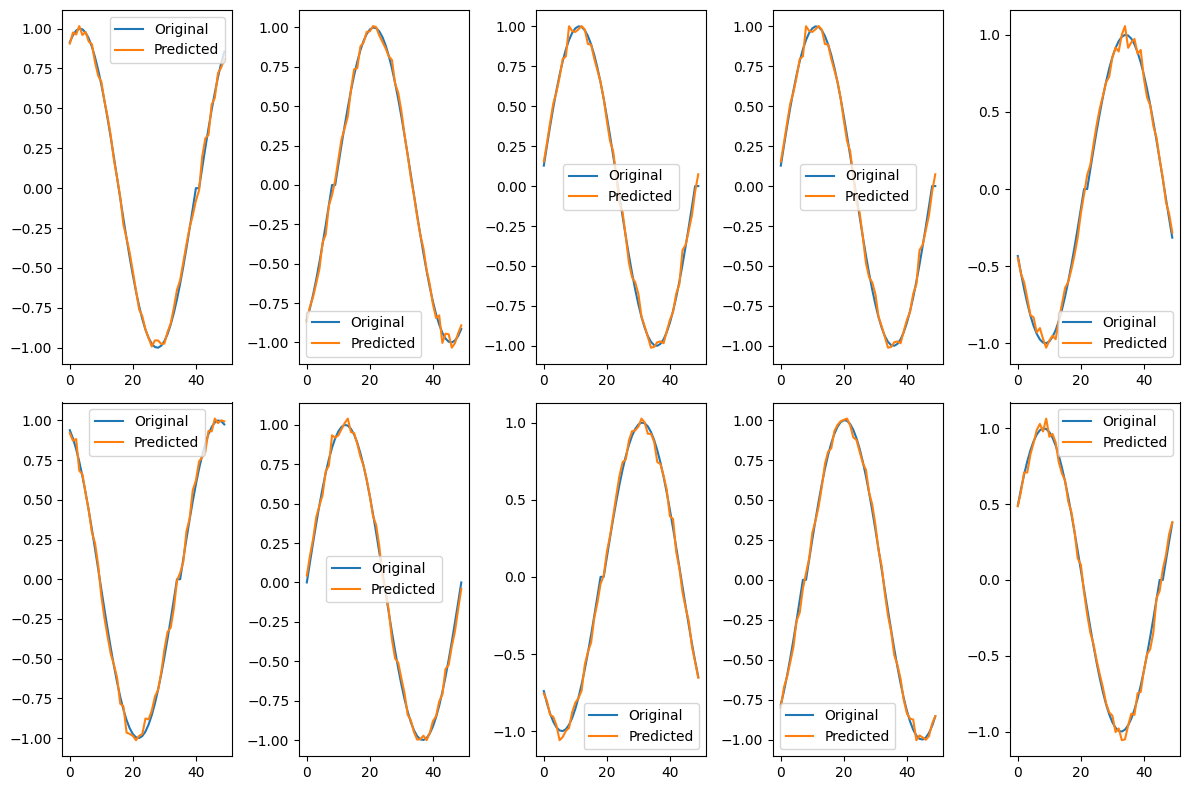

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# generate sine wave data
def generate_sine_wave_data(num_samples, sequence_length):
    x = np.linspace(0, 2 * np.pi, sequence_length)
    y = np.sin(x)
    data = np.array([np.roll(y, i) for i in range(num_samples)])
    return data

# encoder
def build_encoder(latent_dim):
    inputs = layers.Input(shape=(50,))
    x = layers.Dense(128, activation='relu')(inputs)
    z = layers.Dense(latent_dim)(x)
    return models.Model(inputs, z, name='encoder')

# decoder
def build_decoder(latent_dim):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    outputs = layers.Dense(50)(x)
    return models.Model(inputs, outputs, name='decoder')

# discriminator
def build_discriminator(latent_dim):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs, name='discriminator')

# params
num_samples = 1000
sequence_length = 50
latent_dim = 20

# get data
data = generate_sine_wave_data(num_samples, sequence_length)
np.random.shuffle(data)

# define models
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)
discriminator = build_discriminator(latent_dim)

# AAE layers
encoder_input = layers.Input(shape=(50,))
encoded = encoder(encoder_input)
decoded = decoder(encoded)

# finalise encoder + decoder model
autoencoder = models.Model(encoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# finalise discriminator model
discriminator.compile(optimizer='adam', loss='binary_crossentropy')

batch_size = 32
epochs = 100
for epoch in range(epochs):
    idx = np.random.randint(0, data.shape[0], batch_size)
    real_data = data[idx]
    
    # Autoencoder training
    autoencoder_loss = autoencoder.train_on_batch(real_data, real_data)
    
    # Discriminator training
    latent_fake = encoder.predict(real_data)
    latent_real = np.random.normal(size=(batch_size, latent_dim))
    combined_latent = np.concatenate([latent_fake, latent_real])
    labels = np.concatenate([np.zeros((batch_size, 1)), np.ones((batch_size, 1))])  # 0 for fake, 1 for real
    d_loss = discriminator.train_on_batch(combined_latent, labels)

    print(f'Epoch {epoch}, Autoencoder Loss: {autoencoder_loss:.4f}, Discriminator Loss: {d_loss:.4f}')

# 取一些样本进行可视化
test_samples = data[:10]
predicted = autoencoder.predict(test_samples)

# 绘制结果
plt.figure(figsize=(12, 8))
for i in range(len(test_samples)):
    plt.subplot(2, 5, i + 1)
    plt.plot(test_samples[i], label='Original')
    plt.plot(predicted[i], label='Predicted')
    plt.legend()

plt.tight_layout()
plt.show()

# train an encoder-decoder model without discriminator

Epoch 1/20
32/32 [==============================] - 0s 602us/step - loss: 0.2073
Epoch 2/20
32/32 [==============================] - 0s 676us/step - loss: 0.0081
Epoch 3/20
32/32 [==============================] - 0s 838us/step - loss: 0.0013
Epoch 4/20
32/32 [==============================] - 0s 820us/step - loss: 5.7866e-04
Epoch 5/20
32/32 [==============================] - 0s 593us/step - loss: 3.8017e-04
Epoch 6/20
32/32 [==============================] - 0s 585us/step - loss: 2.8569e-04
Epoch 7/20
32/32 [==============================] - 0s 610us/step - loss: 2.2658e-04
Epoch 8/20
32/32 [==============================] - 0s 609us/step - loss: 1.8962e-04
Epoch 9/20
32/32 [==============================] - 0s 576us/step - loss: 1.6313e-04
Epoch 10/20
32/32 [==============================] - 0s 596us/step - loss: 1.4563e-04
Epoch 11/20
32/32 [==============================] - 0s 598us/step - loss: 1.3385e-04
Epoch 12/20
32/32 [==============================] - 0s 750us/step - loss: 

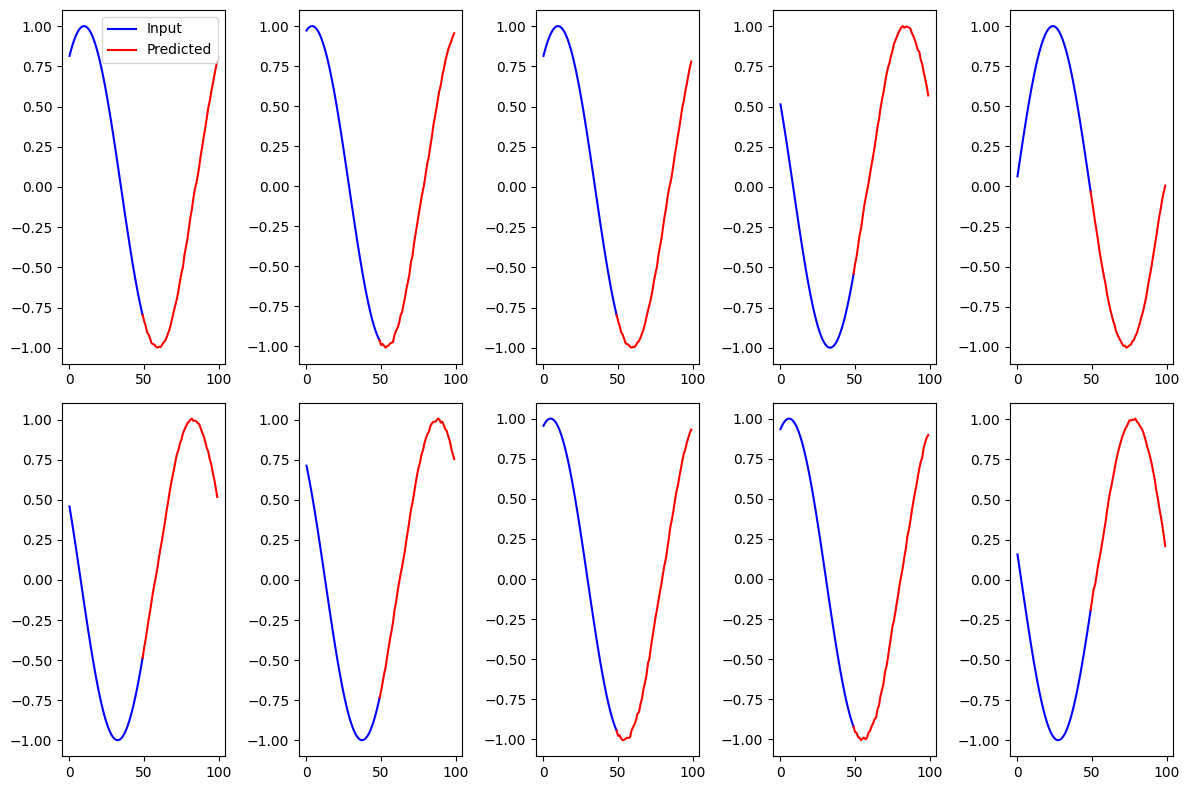

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# data generator
def generate_sine_wave_data(num_samples, sequence_length):
    x = np.linspace(0, 2 * np.pi, sequence_length)  # full cycle
    y = np.sin(x)
    input_data = []
    output_data = []
    for _ in range(num_samples):
        start = np.random.randint(0, sequence_length // 2)  # get a random start point in the first half cycle
        end = start + sequence_length // 2  
        input_data.append(y[start:end])
        output_data.append(np.concatenate([y[end:], y[:start]]))  # predict the rest of the cycle
    return np.array(input_data), np.array(output_data)


def build_encoder(latent_dim, input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(128, activation='relu')(inputs)
    z = layers.Dense(latent_dim)(x)
    return models.Model(inputs, z, name='encoder')


def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    outputs = layers.Dense(output_shape[0])(x)
    return models.Model(inputs, outputs, name='decoder')

# params
num_samples = 1000
sequence_length = 100
input_length = output_length = sequence_length // 2
latent_dim = 20

# get data
input_data, output_data = generate_sine_wave_data(num_samples, sequence_length)

# define models
encoder = build_encoder(latent_dim, (input_length,))
decoder = build_decoder(latent_dim, (output_length,))

# autoencoder layers
encoder_input = layers.Input(shape=(input_length,))
encoded = encoder(encoder_input)
decoded = decoder(encoded)

autoencoder = models.Model(encoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# train
autoencoder.fit(input_data, output_data, epochs=20, batch_size=32)

# draw results
test_samples = input_data[:10]
predicted = autoencoder.predict(test_samples)

plt.figure(figsize=(12, 8))
for i in range(len(test_samples)):
    plt.subplot(2, 5, i + 1)
    plt.plot(test_samples[i], color='blue', label='Input') #the given part 
    predicted_full = np.concatenate([test_samples[i][-1:], predicted[i]])  
    plt.plot(np.arange(input_length-1, input_length + output_length), predicted_full, color='red', label='Predicted') # the predicted part
    if i == 0:
        plt.legend()


plt.tight_layout()
plt.show()


# AAE with first part of sine wave as input and second part as prediction

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt

# data generator
def generate_sine_wave_data(num_samples, sequence_length):
    x = np.linspace(0, 2 * np.pi, sequence_length)  # full cycle
    y = np.sin(x)
    input_data = []
    output_data = []
    for _ in range(num_samples):
        start = np.random.randint(0, sequence_length // 2)  # get a random start point in the first half cycle
        end = start + sequence_length // 2  
        input_data.append(y[start:end])
        output_data.append(np.concatenate([y[end:], y[:start]]))  # predict the rest of the cycle
    return np.array(input_data), np.array(output_data)

def build_encoder(latent_dim, input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(128, activation='relu')(inputs)
    z = layers.Dense(latent_dim)(x)
    return models.Model(inputs, z, name='encoder')


def build_decoder(latent_dim, output_shape):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    outputs = layers.Dense(output_shape[0])(x)
    return models.Model(inputs, outputs, name='decoder')

# discriminator
def build_discriminator(latent_dim):
    inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs, name='discriminator')

# params
num_samples = 1000
sequence_length = 100
input_length = output_length = sequence_length // 2
latent_dim = 20
batch_size = 32
epochs = 70

# get data
input_data, output_data = generate_sine_wave_data(num_samples, sequence_length)

# define model layers
encoder = build_encoder(latent_dim, (input_length,))
decoder = build_decoder(latent_dim, (output_length,))
discriminator = build_discriminator(latent_dim)


# discriminator layers
discriminator.compile(loss='binary_crossentropy', optimizer='adam')

# Autoencoder Model for training
encoder_input = layers.Input(shape=(input_length,))
encoded = encoder(encoder_input)
decoded = decoder(encoded)

autoencoder = models.Model(encoder_input, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Combine encoder and discriminator for the adversarial model
discriminator.trainable = False  # Ensure the discriminator's layers are not trainable during GAN training
validity = discriminator(encoded)
adversarial_autoencoder = models.Model(encoder_input, [decoded, validity])
adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'], optimizer='adam', loss_weights=[0.999, 0.001])

# Training loop
for epoch in range(epochs):
    idx = np.random.randint(0, input_data.shape[0], batch_size)
    real_inputs = input_data[idx]
    real_outputs = output_data[idx]

    # Train discriminator
    z_fake = encoder.predict(real_inputs)
    z_real = np.random.normal(size=(batch_size, latent_dim))

    fake = np.zeros((batch_size, 1))
    real = np.ones((batch_size, 1))

    d_loss_real = discriminator.train_on_batch(z_real, real)
    d_loss_fake = discriminator.train_on_batch(z_fake, fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train autoencoder
    g_loss = adversarial_autoencoder.train_on_batch(real_inputs, [real_outputs, real])

    # Print the progress
    print(f"Epoch: {epoch+1}/{epochs}, D Loss: {d_loss}, G Loss: {g_loss[0]}")

# Visualization of the results
test_samples = input_data[:10]
predicted = autoencoder.predict(test_samples)






1/1 [==============================] - 0s 21ms/step
Epoch: 1/70, D Loss: 0.6891477704048157, G Loss: 0.5376306772232056
1/1 [==============================] - 0s 9ms/step
Epoch: 2/70, D Loss: 0.634931743144989, G Loss: 0.5009708404541016
1/1 [==============================] - 0s 9ms/step
Epoch: 3/70, D Loss: 0.5741695761680603, G Loss: 0.4583967924118042
1/1 [==============================] - 0s 9ms/step
Epoch: 4/70, D Loss: 0.5572708994150162, G Loss: 0.4392470717430115
1/1 [==============================] - 0s 8ms/step
Epoch: 5/70, D Loss: 0.5342523604631424, G Loss: 0.4083077907562256
1/1 [==============================] - 0s 8ms/step
Epoch: 6/70, D Loss: 0.5318144261837006, G Loss: 0.3832331597805023
1/1 [==============================] - 0s 9ms/step
Epoch: 7/70, D Loss: 0.518748477101326, G Loss: 0.3552996516227722
1/1 [==============================] - 0s 8ms/step
Epoch: 8/70, D Loss: 0.4778783246874809, G Loss: 0.3285312056541443
1/1 [==============================] - 0s 10ms/st

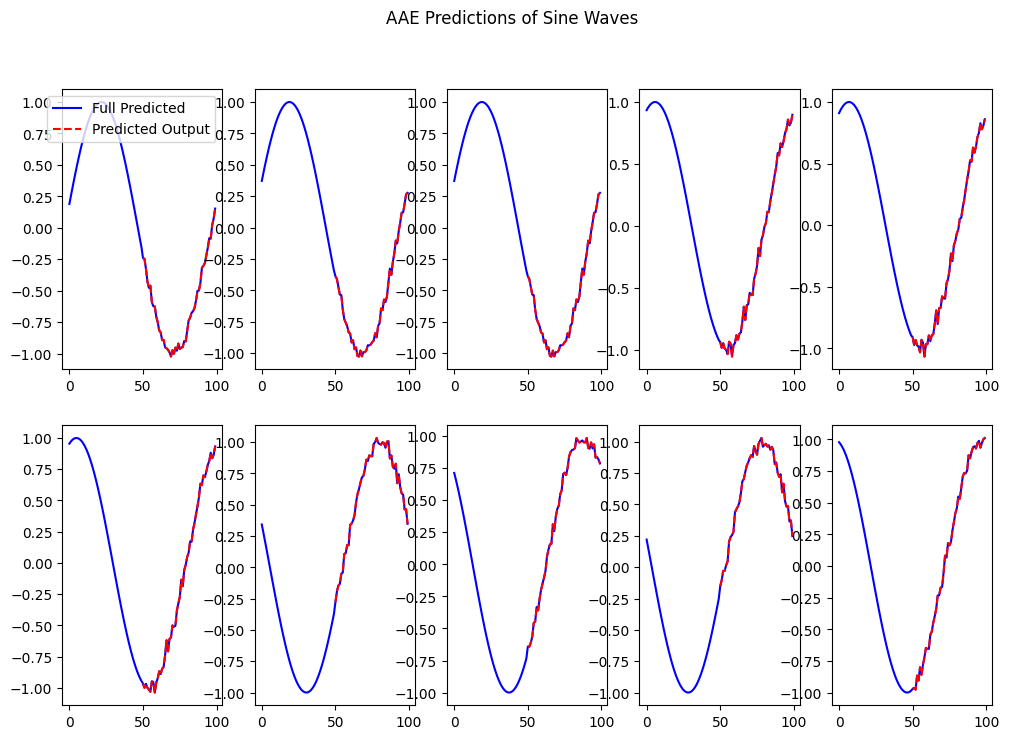

In [19]:
plt.figure(figsize=(12, 8))
for i in range(len(test_samples)):
    plt.subplot(2, 5, i + 1)
    #plt.plot(np.arange(input_length), test_samples[i], color='g', label='Input')
    full_prediction = np.concatenate([test_samples[i], predicted[i]])
    # 画完整的预测，包括已知的输入和预测的输出部分
    plt.plot(np.arange(input_length + output_length), full_prediction, color='b', label='Full Predicted')
    # 使用不同颜色突出显示预测的输出部分
    plt.plot(np.arange(input_length, input_length + output_length), predicted[i], color='r', linestyle='--', label='Predicted Output')
    if i == 0:
        plt.legend(loc='upper right')
plt.suptitle('AAE Predictions of Sine Waves')
plt.show()


it can be observed that AAE model can generate the rest of the sine wave with a moderate accuracy. but compared with purely using VAE, the result is not better. there are more glitches seen in the prediction of AAE.